<a href="https://colab.research.google.com/github/jwells52/creating-ai-enabled-systems/blob/main/Research%20Project/notebooks/fsl_experiment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install easyfsl

In [1]:
%pip install easyfsl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.2/65.2 kB 546.3 kB/s eta 0:00:00


### Download Humpback Whale Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -rf /root/.kaggle && mkdir /root/.kaggle && cp /content/drive/MyDrive/Research-Project/kaggle.json /root/.kaggle/kaggle.json && chmod 600 /root/.kaggle/kaggle.json && kaggle competitions download -c humpback-whale-identification

100% 5.49G/5.51G [00:55<00:00, 114MB/s]
100% 5.51G/5.51G [00:55<00:00, 107MB/s]


In [4]:
%%capture

!unzip humpback-whale-identification.zip

### Clone GitHub Repo

In [5]:
import os

if os.path.exists('/content/creating-ai-enabled-systems/Research Project') == False:
  !git clone https://github.com/jwells52/creating-ai-enabled-systems.git

%cd creating-ai-enabled-systems/Research\ Project

Cloning into 'creating-ai-enabled-systems'...
remote: Enumerating objects: 352, done.
remote: Counting objects: 100% (165/165), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 352 (delta 102), reused 23 (delta 7), pack-reused 187
Receiving objects: 100% (352/352), 159.28 MiB | 27.93 MiB/s, done.
Resolving deltas: 100% (181/181), done.
Updating files: 100% (53/53), done.
/content/creating-ai-enabled-systems/Research Project


### Imports

In [6]:
import os
import cv2
import torch

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from easyfsl.methods import PrototypicalNetworks, FewShotClassifier, SimpleShot
from easyfsl.utils import evaluate, evaluate_on_one_task
from easyfsl.samplers import TaskSampler

from torch import Tensor, nn
from torch.optim import SGD, Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, resnet34, resnet152

from typing import Callable

from modules.data_utils import HumpbackWhaleDataset, remove_new_whale_class, create_loader
from modules.train import train_fsl, device, transform


%load_ext autoreload
%autoreload 2

In [25]:
n_way   = 5
n_shot  = 3
n_query = 3

### Look at classes that have low performance

In [8]:
# Load into dataset
# For each class, calculate accuracy
# Then plot barplot of accuracy for each class
# Look at the characteristics of images for the classes that have low performance

In [40]:
df = remove_new_whale_class(
  pd.read_csv('/content/creating-ai-enabled-systems/Research Project/data/images_and_ids.csv')
)

df = df[df.class_count >= 10]

In [41]:
dataset = HumpbackWhaleDataset('/content/train', df, transform=transform)

In [51]:
sampler = TaskSampler(
    dataset, n_way=n_way, n_shot=n_shot, n_query=n_query, n_tasks=500
)

In [52]:
loader = DataLoader(
    dataset,
    batch_sampler=sampler,
    num_workers=2,
    pin_memory=True,
    collate_fn=sampler.episodic_collate_fn
)


In [53]:
cnn = resnet34()
cnn.fc = torch.nn.Flatten()
few_shot_classifier = PrototypicalNetworks(cnn).to(device)
few_shot_classifier.load_state_dict(
  torch.load('/content/drive/MyDrive/prototypical_network_resnet18_last_epoch')()
)

<All keys matched successfully>

In [54]:
%%capture

few_shot_classifier.eval()

In [55]:
class_accs = dict()
for (support_images, support_labels, query_images, query_labels, whale_ids) in tqdm(loader):

    few_shot_classifier.process_support_set(support_images.to(device), support_labels.to(device))
    predictions = few_shot_classifier(query_images.to(device)).detach().data
    prediction_labels = torch.max(predictions, 1)[1].cpu().detach().data

    for label in torch.unique(query_labels):

      label_idxs = torch.argwhere(query_labels == label)
      whale_id_acc = (prediction_labels[label_idxs] == query_labels[label_idxs]).sum().item() / n_query
      whale_id = dataset.id_to_label[whale_ids[label.detach().item()]]

      if whale_id not in class_accs:
        class_accs[whale_id] = [whale_id_acc]
      else:
        class_accs[whale_id] += [whale_id_acc]

100%|██████████| 500/500 [03:44<00:00,  2.22it/s]


In [56]:
class_acc_means = dict()
class_acc_means = {k:np.mean(v) for k, v in class_accs.items()}

In [57]:
len(class_acc_means.keys())


273

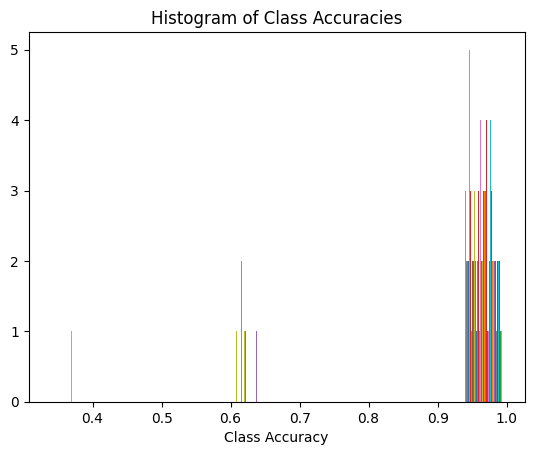

In [49]:
plt.title('Histogram of Class Accuracies')
plt.hist(class_accs.values())
plt.xlabel('Class Accuracy');

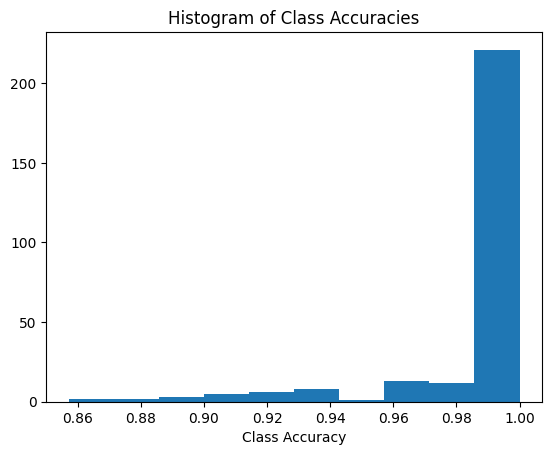

In [58]:
plt.title('Histogram of Class Accuracies')
plt.hist(class_acc_means.values())
plt.xlabel('Class Accuracy');

In [ ]:
# Look at whale_ids that are in the lower spectrum of the histogram

In [59]:
low_performance_classes = []
for k, v in class_acc_means.items():
  if v <= .90:
    low_performance_classes += [k]

In [60]:
low_performance_classes

['w_8b86b95',
 'w_ec32fa6',
 'w_343f088',
 'w_f829227',
 'w_5d5c6a6',
 'w_9a91c1e',
 'w_16df050',
 'w_c8bbb43']

In [65]:
df[df['Id'] == 'w_8b86b95']['Image']

365      05e81e346.jpg
1584     1ab5e0f55.jpg
2730     2d742ff03.jpg
5428     5a8caa94c.jpg
5998     630f0f209.jpg
6734     6f2ee2644.jpg
9870     a17f20cc5.jpg
10899    b18fcea7f.jpg
11567    bcaa89ec6.jpg
11994    c3fd63c88.jpg
12520    cbd8c40a2.jpg
12601    cd444321e.jpg
13237    d796f62ee.jpg
13979    e39e15075.jpg
15508    fc73edd89.jpg
Name: Image, dtype: object

In [62]:
img_filename = df[df['Id'] == 'w_2df85e7']['Image'].iloc[1]

In [77]:
img = cv2.imread(f'/content/train/a17f20cc5.jpg')

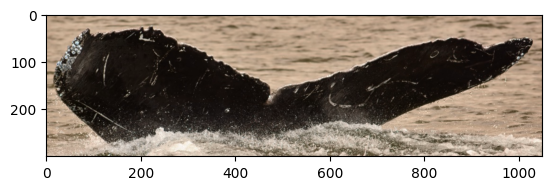

In [78]:
plt.imshow(img)